In [8]:
from preprocessing.DataList import *

import torch
import cv2
import torch.nn as nn
import matplotlib.pyplot as plt
# Set default figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 10.0)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Extracting the data

In [3]:
# Extract the training data  
labelPath = '/home/rasad/Documents/LFW_annotation_train.txt'
baseImagePath = '/home/rasad/Documents/lfw'
data = DataList(labelPath, baseImagePath)
# Create a data list
data.MakeList()

## Visualization of the input
Now let's try to visualize some of the images to make sure they are as expected. Most importantly <br/>
we want to see if the land marks are where they are supposed to be.

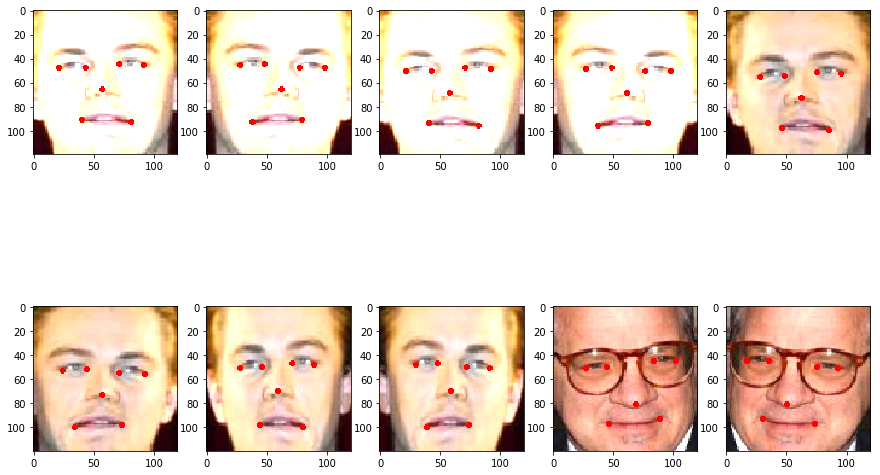

In [5]:
NUM_IMGS = 10
Xsample = data.X[:NUM_IMGS].copy()
ySample = data.y[:NUM_IMGS].copy()

for i in range(1,NUM_IMGS+1):
    img = np.asarray(Xsample[i-1])
    img = img.astype('uint8')
    img = np.ascontiguousarray(img)
    # Add the landmarks
    landMarks = np.asarray(ySample[i-1])
    for j, (x,y) in enumerate(landMarks):
        cv2.circle(img, (x,y), 1, 255.0, thickness=2)
    # Plot the image
    plt.subplot(2, NUM_IMGS/2, i)
    plt.imshow(img, )
plt.show()

## Splitting data to train and validation

In [4]:
data.DataSplit()

Shuffling chunk 0 / 100
Shuffling chunk 20 / 100
Shuffling chunk 40 / 100
Shuffling chunk 60 / 100
Shuffling chunk 80 / 100


## Let's save the DataLists that we created in hdf5 format
First I'm going to dump the train and validation data into hdf5

In [19]:
import h5py 

# Make sure the file is not already open
try:
    hdf5.close()
except:
    print("The file is not open. Proceeding with saving the data ...")
    
hdf5 = h5py.File('data.h5', 'w')

hdf5.create_dataset('Xtrain', data=data.Xtrain, dtype=np.float32)
hdf5.create_dataset('yTrain', data=data.yTrain, dtype=np.float32)
hdf5.create_dataset('Xval', data=data.Xval, dtype=np.float32)
hdf5.create_dataset('yVal', data=data.yVal, dtype=np.float32)
hdf5.close()

In [497]:
# Now we can load the train and validation datasets.
hdf5 = h5py.File('data.h5', 'r')
Xtrain = np.asarray(hdf5.get('Xtrain'))
yTrain = np.asarray(hdf5.get('yTrain'))
Xval = np.asarray(hdf5.get('Xval'))
yVal = np.asarray(hdf5.get('yVal'))

print("Training data has shape: {}". format(Xtrain.shape))
print("Validation data has shape: {}". format(Xval.shape))
hdf5.close()

Training data has shape: (80000, 40, 40, 3)
Validation data has shape: (20000, 40, 40, 3)


## Let's feed the data to DataLoader

In [5]:
from preprocessing.DataSet import *
from torch.utils.data import DataLoader
from utility.Solver import *

trainDataSet = LFWDataset(data.Xtrain, data.yTrain)
valDataSet = LFWDataset(data.Xval, data.yVal)
solver = Solver(trainDataSet, valDataSet, batchSize=64)

The batch has shape: torch.Size([64, 3, 224, 224])
There are 14 land mark coordinates on each face


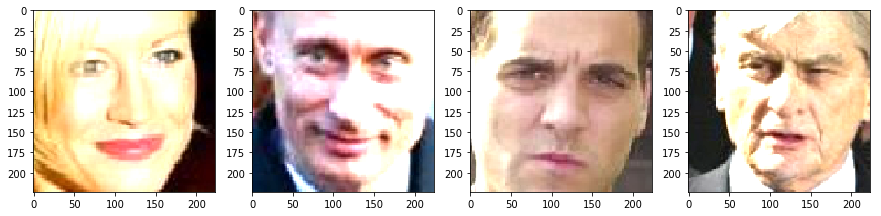

In [6]:
with torch.no_grad():
    # Now I'm going to read a few data examples from the DataLoader and plot them
    idx, (imgages, landMarks) = next(enumerate(solver.trainLoader))

    print("The batch has shape: {}".format(imgages.shape))
    print("There are {} land mark coordinates on each face".format(len(landMarks[0])))

    NUM_IMGS = 4
    for i in range(1, NUM_IMGS+1):
        img = np.asarray(imgages[i-1]).transpose(1, 2, 0)
        img = (1+img) * 255.0 / 2.0
        img = np.ascontiguousarray(img.astype('uint8'))
        plt.subplot(1, NUM_IMGS, i)
        plt.imshow(img)
    plt.show()

## We are now going to use transfer learning to detect land marks.
I'm going to do the following steps:
* Download the pretrained alexnet model.
* Create an instance of my fully connected model (LandMarkAlexNet).
* Set the classifier portion of alexnet to the one I created.

In [43]:
# Downloading the pretrained alexnet
from torchvision import models

alexnet = models.alexnet(pretrained=True)

In [25]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [49]:
# Set requirement of gradient to False for all layers
for param in alexnet.parameters():
    param.requires_grad = False

# Set the requirement of gradient for the third block in the last layer to true.
for param in alexnet.features[3:].parameters():
    param.requires_grad = True


alexnet.features.add_module(module=nn.BatchNorm2d(192), name='4')
alexnet.features.add_module(module=nn.ReLU(inplace=True), name='5')
alexnet.features.add_module(module=nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, 
                                             ceil_mode=False), name='6')
alexnet.features.add_module(module= nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), 
                                          padding=(1, 1)), name='7')
alexnet.features.add_module(module=nn.BatchNorm2d(384), name='8')
alexnet.features.add_module(module=nn.ReLU(inplace=True), name='9')
alexnet.features.add_module(module= nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), 
                                           padding=(1, 1)), name='10')
alexnet.features.add_module(module=nn.BatchNorm2d(256), name='11')
alexnet.features.add_module(module=nn.ReLU(inplace=True), name='12')

alexnet.features.add_module(module=nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), name='13')
alexnet.features.add_module(module=nn.BatchNorm2d(256), name='14')
alexnet.features.add_module(module=nn.ReLU(inplace=True), name='15')
alexnet.features.add_module(module=nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), name='16')
alexnet.features.add_module(module=nn.BatchNorm2d(256), name='17')
alexnet.features.add_module(module=nn.ReLU(inplace=True), name='18')
alexnet.features.add_module(module=nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, 
                                                ceil_mode=False), name='19')
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0

In [50]:
# Now I extract the number of input features for the classifier portion of
# the alexnet model
numInFeatures = alexnet.classifier[1].in_features

In [51]:
from models.Classifier import * 

# Let's create an instance of my model and set the classifier portion of
# the alexnet to my model.
model = Classifier(numInFeatures)
alexnet.classifier = model
alexnet = alexnet.cuda()

In [14]:
# Load the model if it exists
net_state = torch.load('alexnet')
alexnet.load_state_dict(net_state)

In [52]:
trainLoss = []
validationLoss = []
optimizer = torch.optim.Adam(alexnet.parameters(), lr=1e-4)
radius = np.arange(5, 50, 5) / 255.0

In [54]:
# Let's train the model
lr = 1e-4
numEpochs = [5, 5, 10, 5]
for i in numEpochs:
    print("Trying learning rate of: {}".format(lr))
    optimizer.param_groups[0]['lr'] = lr
    tLoss, vLoss, finalAccuracy = solver.train(alexnet, optimizer, numEpochs=i, printEvery=200,
                                               radius=radius, radiusEvalIdx=0)
    trainLoss += tLoss
    validationLoss += vLoss
    # Save the model
    net_state = alexnet.state_dict()
    torch.save(net_state, 'alexnet')    
    lr *= 0.1

Trying learning rate of: 0.0001
This is epoch 0
Epoch 0, iteration 0 : loss is 0.0006207
The accuracy on validation set for radius 0.0196078431372549 is: 30.041964285714286
Epoch 0, iteration 200 : loss is 0.0015680
The accuracy on validation set for radius 0.0196078431372549 is: 20.62142857142857
Epoch 0, iteration 400 : loss is 0.0007245
The accuracy on validation set for radius 0.0196078431372549 is: 37.84196428571428
Epoch 0, iteration 600 : loss is 0.0004058
The accuracy on validation set for radius 0.0196078431372549 is: 37.705357142857146
Epoch 0, iteration 800 : loss is 0.0004746
The accuracy on validation set for radius 0.0196078431372549 is: 40.64017857142857
--------
This is epoch 1
Epoch 1, iteration 0 : loss is 0.0007140
The accuracy on validation set for radius 0.0196078431372549 is: 32.04464285714286
Epoch 1, iteration 200 : loss is 0.0003704
The accuracy on validation set for radius 0.0196078431372549 is: 35.48571428571429
Epoch 1, iteration 400 : loss is 0.0006660
The 

The accuracy on validation set for radius 0.0196078431372549 is: 70.87053571428571
Epoch 3, iteration 600 : loss is 0.0001365
The accuracy on validation set for radius 0.0196078431372549 is: 71.56785714285714
Epoch 3, iteration 800 : loss is 0.0001376
The accuracy on validation set for radius 0.0196078431372549 is: 69.70982142857143
--------
This is epoch 4
Epoch 4, iteration 0 : loss is 0.0001796
The accuracy on validation set for radius 0.0196078431372549 is: 70.96160714285715
Epoch 4, iteration 200 : loss is 0.0002830
The accuracy on validation set for radius 0.0196078431372549 is: 70.73660714285714
Epoch 4, iteration 400 : loss is 0.0001328
The accuracy on validation set for radius 0.0196078431372549 is: 70.09107142857142
Epoch 4, iteration 600 : loss is 0.0001823
The accuracy on validation set for radius 0.0196078431372549 is: 70.05892857142857
Epoch 4, iteration 800 : loss is 0.0002481
The accuracy on validation set for radius 0.0196078431372549 is: 69.89375
--------
This is epoc

In [55]:
# Save the model
net_state = alexnet.state_dict()
torch.save(net_state, 'alexnet')


In [58]:
# Save the train and validation loss
np.savetxt('trainLoss2', np.asarray(trainLoss[:2000]))
np.savetxt('validationLoss2', np.asarray(validationLoss[:2000]))

In [59]:
# Take predictions on a batch
imgs, batchLandmarks, batchPredictions = solver.ReturnBatchPrediction(alexnet)

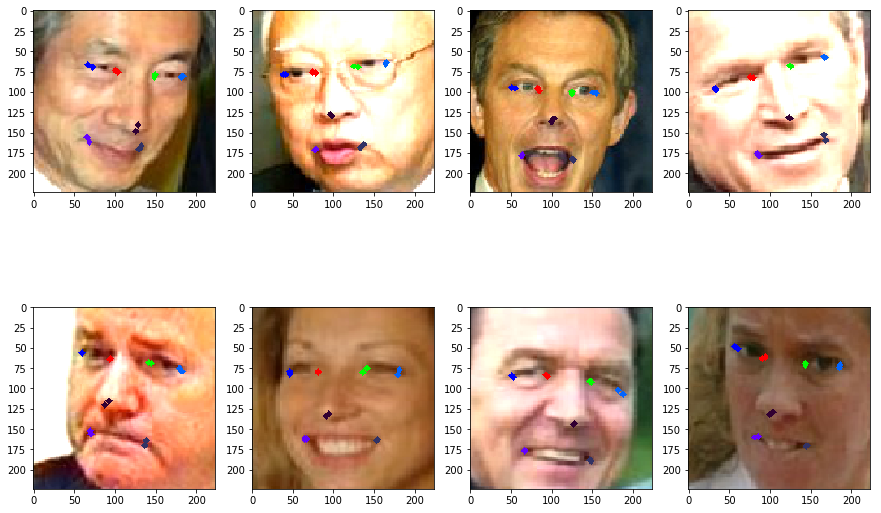

In [60]:
# Plot predictions on batch images
NUM_IMGS = 8

for idx in range(1, NUM_IMGS+1):
    # Select and copy
    img = imgs[idx-1]
    landmarks = batchLandmarks[idx-1]
    predictions = batchPredictions[idx-1]

    # Scale back
    img = np.asarray(img).transpose(1, 2, 0)
    img = (1+img) * 255.0 / 2.0
    landmarks = np.asarray(landmarks) * 255.0
    landmarks = landmarks.reshape(7,2)
    predictions = np.asarray(predictions) * 255.0
    predictions = predictions.reshape(7,2)

    # Plot Images
    img = np.ascontiguousarray(img.astype('uint8'))

    # Add the ground truth landmarks
    colors = [[0,0,255], [255,0,0], [0,255,0], [0,100, 255],
              [100, 0, 255], [50,50,100], [50, 0, 50]]
    for i, (x,y) in enumerate(landmarks):
        cv2.circle(img, (x,y), 2, colors[i], thickness=3)

    # Add prediction landmarks
    for i, (x,y) in enumerate(predictions):
        cv2.circle(img, (x,y), 2, colors[i], thickness=3)

    plt.subplot(2, NUM_IMGS/2, idx)
    plt.imshow(img)

plt.show()

In [22]:
# Compute the loss and accuracy on the validation dataset
radius = np.arange(5, 50, 5) / 255.0
_, validationAccuracy = solver.ComputeAccuracy(alexnet, solver.validationLoader, 
                                                            torch.nn.MSELoss(), radius=radius)

In [3]:
# Lets load the train loss and validation loss
trainLoss = np.loadtxt('trainLoss')
validationLoss = np.loadtxt('validationLoss')

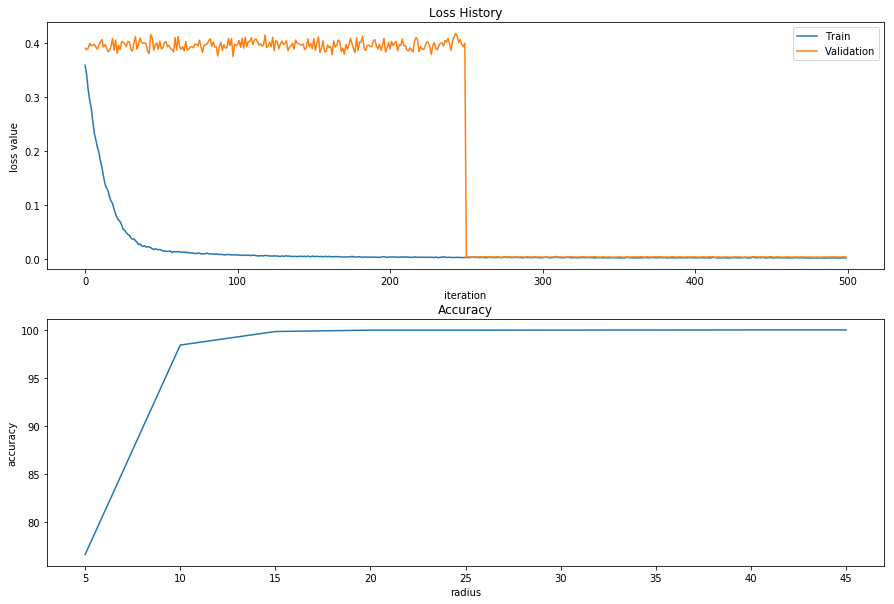

In [10]:
# Let's take a look at the trainig and validation loss history after full training
after = 0
upTo = 500
plt.subplot(2, 1, 1)
plt.title("Loss History")
plt.xlabel("iteration")
plt.ylabel("loss value")
plt.plot(trainLoss[after:upTo], label='Train')
plt.plot(validationLoss[after:upTo], label='Validation')
plt.legend()

plt.subplot(2, 1, 2)
plt.title("Accuracy")
plt.xlabel("radius")
plt.ylabel("accuracy")
plt.plot(np.asarray(list(finalAccuracy.keys()))*255.0, finalAccuracy.values())
plt.savefig('Loss and Accuracy.png')
plt.show()

In [63]:
# Extract the test data  
labelPath = '/home/rasad/Documents/LFW_annotation_test.txt'
baseImagePath = '/home/rasad/Documents/lfw'
data = DataList(labelPath, baseImagePath)
# Create a data list
data.MakeListTest()

In [67]:
# Create a dataset from the datalist 
testDataSet = LFWDataset(data.X, data.y)

# Create a DataLoader for the test dataset
testLoader = DataLoader(testDataSet, batch_size= 64,
                        shuffle=True, num_workers=6)



In [68]:
# Compute the loss and accuracy on the test dataset
_, testAccuracy = solver.ComputeAccuracy(alexnet, testLoader, torch.nn.MSELoss(), radius=radius)

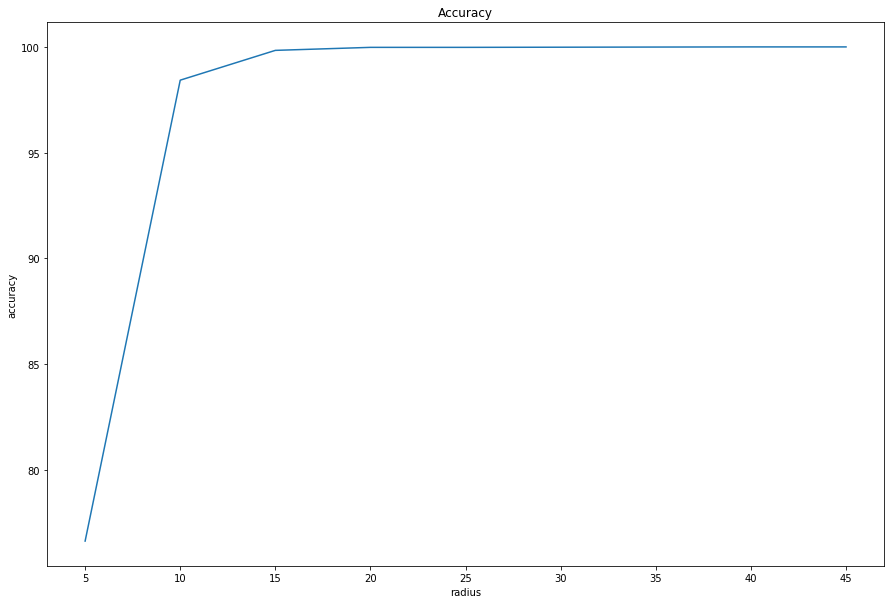

In [69]:
# Let's take a look at the test accuracy
plt.title("Accuracy")
plt.xlabel("radius")
plt.ylabel("accuracy")
plt.plot(np.asarray(list(testAccuracy.keys()))*255.0, testAccuracy.values())
plt.savefig('Test Data Accuracy.png')

In [71]:
print("The test accuracies are:")
dict(zip(list(np.asarray(list(testAccuracy.keys()))*255.0), testAccuracy.values()))

The test accuracies are:


{5.0: 76.62467079507438,
 10.0: 98.42693430137376,
 15.0: 99.83628728023348,
 20.0: 99.97864616698698,
 25.0: 99.97864616698698,
 30.0: 99.98576411132464,
 35.0: 99.99288205566232,
 40.0: 100.0,
 45.0: 100.0}